In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

We start by loading in and cleaning the data. The process of cleaning the data involves taking the beam and subtracting off the an average of the ambient noise in the room. From this, we then subtract of the dark to remove the hot pixels.
$$
    I_{\textrm{cleaned}}(x,y) = 
    \left[
        I_{\textrm{Beam}}(x,y) - I_{\textrm{Ambient}}(x,y)
    \right] - I_{\textrm{Dark}}(x,y)
$$
When this is done, we end up with the outer region intensity values being negative. This is due to the fact that in the beam dataset, the edges of the CCD get less fluence. This is due to the large flux value of the beam in the center causing radial darkening out at the edges similar to a camera pointing at a bright source (Find a source and better explination). To fix this, we renormalize the data such that the minimum intensity is our new zero point. All other intensity values are measured relative to this.

In [3]:
# Loads in all the data from the master data folder
data_path  = '../01-Data\master_data'
data_files = [f for f in os.listdir(data_path) if f.endswith('.csv')]
data       = [np.loadtxt(os.path.join(data_path, file), delimiter=',') for file in data_files]

dark    = data[0]
beam    = data[1]
ambient = data[2]

In [11]:
np.min(beam-ambient)

-56.8

In [6]:
# Gets the cleaned beam data and the coordinate variables
# cleaned_beam = (beam - ambient) - dark # Subtracted
cleaned_beam = beam  # Un-subtracted

dim_y, dim_x = cleaned_beam.shape
x_pix = np.linspace(0,10, dim_x)
y_pix = np.linspace(0,10, dim_y)

dx = 6.45 # micrometers
dy = dx
x_coords = x_pix * dx
y_coords = y_pix * dy

Now we can plot the beam

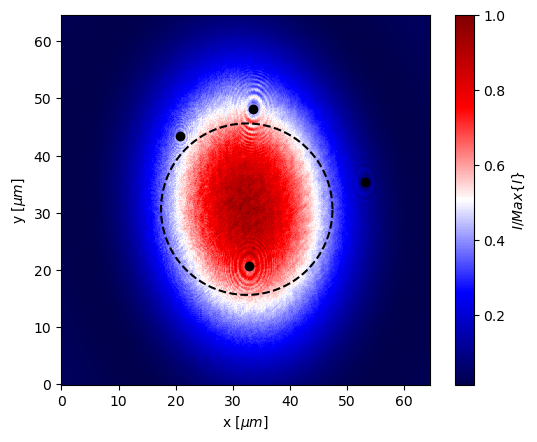

In [7]:
# Plots the master dark
cmap =  'seismic'
fig,ax = plt.subplots()
ax.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), label='cleaned beam', cmap = cmap)
ax.set_xlabel('x $[\mu m]$')
ax.set_ylabel('y [$\mu m$]')

# Sets a colourbar
cbar = plt.colorbar(ax.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), cmap = cmap))
# cbar = plt.colorbar(ax.pcolormesh(master_dark, cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')
ax.set_aspect('equal')

# Sets the middle of the plot
ix = 265
iy = 180
x_center = x_coords[ix]
y_center = y_coords[iy]
# ax.axvline(x_center, color='k', linestyle='--')
# ax.axhline(y_center, color='k', linestyle='--')

# Plots a circle around the chosen center
R = 15
theta = np.linspace(0,2*np.pi,1000)
x_circ = x_center + R*np.cos(theta)
y_circ = y_center + R*np.sin(theta)
ax.plot(x_circ, y_circ, 'k--')

# Plots points at the center of each dust
# particle diffraction pattern
# particle 1
i1x = x_coords[274]
i1y = y_coords[283]
ax.plot(i1x, i1y, 'ko')

# # particle 2
i2x = x_coords[268]
i2y = y_coords[122]
ax.plot(i2x,i2y, 'ko')

# # particle 3
i3x = x_coords[170]
i3y = y_coords[255]
ax.plot(i3x,i3y, 'ko')

# # particle 4
i3x = x_coords[434]
i3y = y_coords[208]
ax.plot(i3x,i3y, 'ko')

We are unable to fit a circle to the beam as it takes the apperance of an ellipse. As the light leaves the pinhole to the CCD, the "ray" does not travel straight on axis, but instead makes an angle with the pinhole-detector axis. This causes us to see a conic sectiono of the beam hence the ellipse. The black dots around the airy disks represent diffraction off of dust located on the (figure out what it is on). This will be the main focus of this study.

Before moving further, we look at the x and y profiles of the beam to ensure the gaussian shape we expect.

Note to self, find an approximation to the angle made by modelling the ellipse

In [8]:
# Defies a gaussian function
def gaussian(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

# Defines a sinc function
def sinc(x, a, b):
    return(a * np.sin(b*x)/x)

In [9]:
# Gets the x and y profiles of the beam
x_profile = cleaned_beam[iy, :]
y_profile = cleaned_beam[:, ix]

# Fits a gaussian to the x and y profiles
x_model = curve_fit(gaussian, x_coords, x_profile)
y_model = curve_fit(gaussian, y_coords, y_profile)

# Calculates the fits
x_fit = gaussian(x_coords, *x_model[0])
y_fit = gaussian(y_coords, *y_model[0])

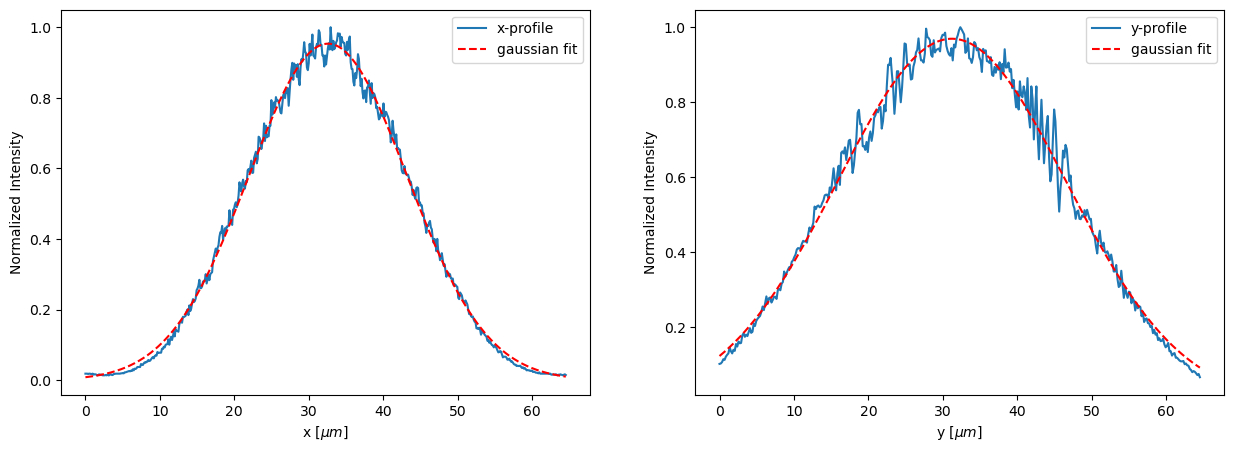

In [10]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# X-profile
ax1.plot(x_coords, x_profile / np.max(x_profile), label='x-profile')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('Normalized Intensity')
ax1.plot(x_coords, x_fit / np.max(x_profile), 'r--', label='gaussian fit')
ax1.legend()
# ax1.set_aspect('equal')

# Y-profile
ax2.plot(y_coords, y_profile / np.max(y_profile), label='y-profile')
ax2.set_xlabel('y [$\mu m$]')
ax2.set_ylabel('Normalized Intensity')
ax2.plot(y_coords, y_fit / np.max(y_profile), 'r--', label='gaussian fit')
ax2.legend()
# ax2.set_aspect('equal')

plt.show()

## Looks at fitting the first dust speck with a funnction (to be determined which)

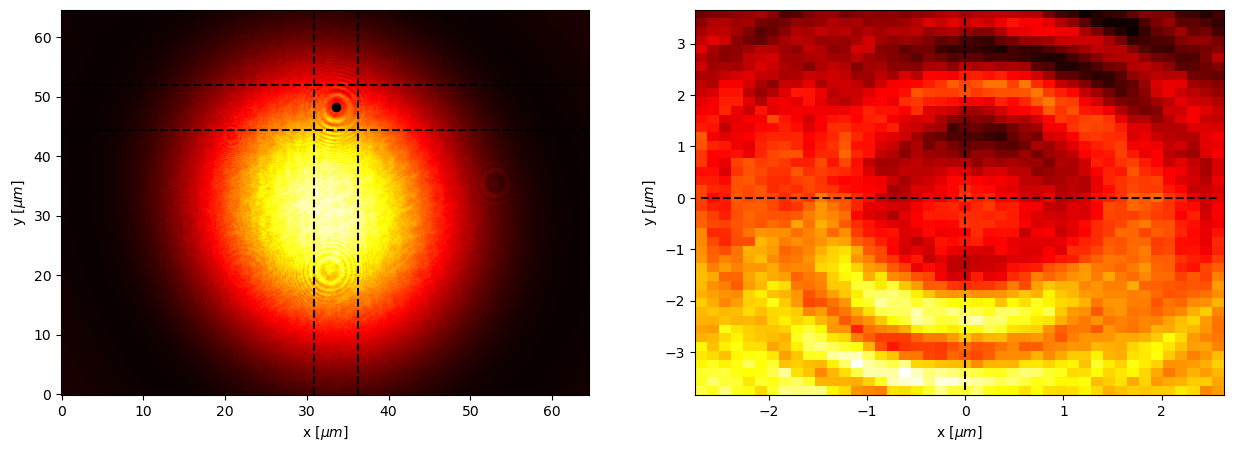

In [11]:
# Plots the master dark
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,5))

## PLot 1: Total Picture
ax1.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), label='cleaned beam', cmap = 'hot')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('y [$\mu m$]')

# Sets a colourbar
cbar = plt.colorbar(ax.pcolormesh(x_coords, y_coords, cleaned_beam / np.max(cleaned_beam), cmap = 'seismic'))
# cbar = plt.colorbar(ax.pcolormesh(master_dark, cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')
# ax1.set_aspect('equal')

# Plots a box around the point of interest
i1x = 274
i1y = 283
ax1.plot(x_coords[i1x], y_coords[i1y], 'ko')
d = 22
x_start = i1x - d; x_end = i1x + d
y_start = i1y - d ; y_end   = i1y + d
ax1.axvline(x_coords[x_start], color='k', linestyle='--')
ax1.axvline(x_coords[x_end], color='k', linestyle='--')
ax1.axhline(y_coords[y_start], color='k', linestyle='--')
ax1.axhline(y_coords[y_end], color='k', linestyle='--')


# Plot 2: Zoomed in picture
# Shifts the coordinates to be centered around the middle of the airy disk
x_shift = x_coords[x_start:x_end] - x_coords[i1x]
y_shift = y_coords[y_start:y_end] - y_coords[i1y]

ax2.pcolormesh(x_shift, y_shift, cleaned_beam[y_start:y_end, x_start:x_end] / np.max(cleaned_beam), label='cleaned beam', cmap = 'hot')
ax2.set_xlabel('x [$\mu m$]')
ax2.set_ylabel('y [$\mu m$]')
cbar = plt.colorbar(ax.pcolormesh(x_shift, y_shift, cleaned_beam[y_start:y_end, x_start:x_end] / np.max(cleaned_beam), cmap = 'hot'))
cbar.set_label('$I/Max\{I\}$')

# Plots lines on the 2nd plot to show plot belows region
ax2.vlines(0, np.min(y_shift), np.max(y_shift), color = 'k', linestyle='--')
ax2.hlines(0, np.min(x_shift), np.max(x_shift), color = 'k', linestyle='--')

In [12]:
# Gets the zoomed in data normalized to the total max intensity
x_profile = cleaned_beam[i1y, x_start:x_end] / np.max(cleaned_beam)
y_profile = cleaned_beam[y_start:y_end,i1x] / np.max(cleaned_beam)

# Fits a sinc function to eachh profile
# poptx, pcovx = curve_fit(sinc, np.arange(len(x_profile)), x_profile)

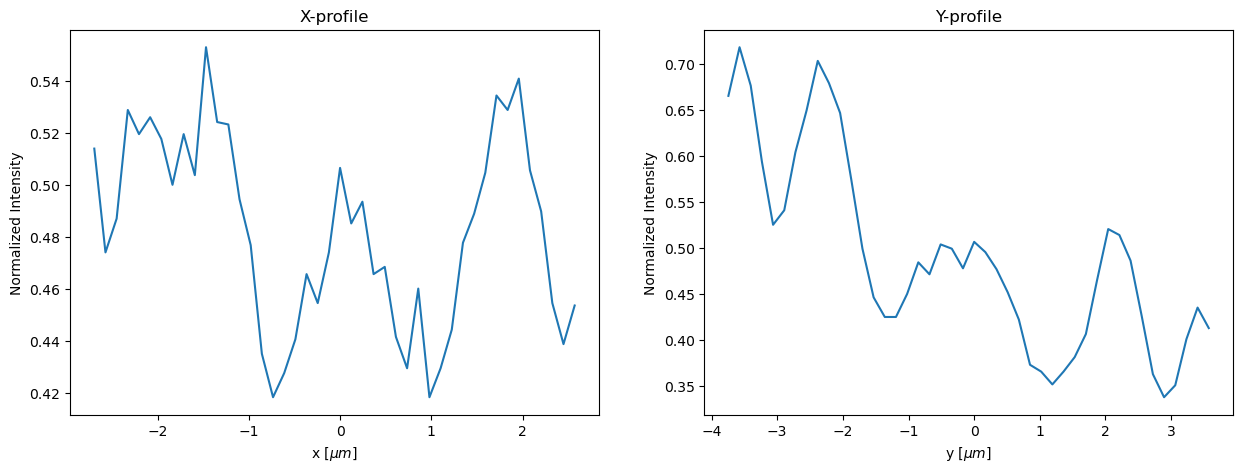

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
# X-profile
ax1.plot(x_shift, x_profile, label='x-profile')
ax1.set_xlabel('x [$\mu m$]')
ax1.set_ylabel('Normalized Intensity')
ax1.set_title('X-profile')

# Y-profile
ax2.plot(y_shift, y_profile, label='y-profile')
ax2.set_xlabel('y [$\mu m$]')
ax2.set_ylabel('Normalized Intensity')
ax2.set_title('Y-profile')

plt.show()


We can see that the profiles are slightly tilted (more prominently in the y-profile). This is due to the varying intensity along the axis. This intensity variation can be quantified by using the profile of the complete filtered beam. Because the beam is elliptical, we can't use the overall profile. A new profile will have to be made on the axis in question.

Fit proper function to the data
$$
    I_x = \frac{1}{(1-\epsilon^2)^2}\left[
        \left(\frac{2J_1(\pi x)}{\pi x}\right)^2 - 
        \epsilon^2\left(\frac{2J_1(\pi \epsilon x)}{\pi \epsilon x}\right)^2
    \right]^2
$$
$$
    I_y = \frac{1}{(1-\epsilon^2)^2}\left[
        \left(\frac{2J_1(\pi y)}{\pi y}\right)^2 - 
        \epsilon^2\left(\frac{2J_1(\pi \epsilon y)}{\pi \epsilon y}\right)^2
    \right]^2
$$
Where 
$$
    \epsilon = R/a
$$
$R = $ radius of the dust $a = $ radius of the incoming beam
$$
    x = ka\sin\theta \approx \frac{2\pi a}{\lambda d}
$$
$$
    y = ka\cos\theta \approx \frac{2\pi a}{\lambda d}
$$

Try subtracting off gaussian for attenuation from dust. (more in the center, less towards the edges of the particle)
$$
    I_{tot}^{x_k} = I_0\left(\frac{2J_1(x_k)}{x_k}\right)^2 - 
                    \alpha e^{-\beta(x_k-\gamma)^2}  
$$